[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with DeepSORT Tracker

DeepSORT extends the original SORT algorithm by integrating appearance information through a deep association metric. While maintaining the core Kalman filtering and Hungarian algorithm components from SORT, DeepSORT adds a convolutional neural network (CNN) trained on large-scale person re-identification datasets to extract appearance features from detected objects. This integration allows the tracker to maintain object identities through longer periods of occlusion, effectively reducing identity switches compared to the original SORT. DeepSORT operates with a dual-metric approach, combining motion information (Mahalanobis distance) with appearance similarity (cosine distance in feature space) to improve data association decisions. It also introduces a matching cascade that prioritizes recently seen tracks, enhancing robustness during occlusions. Most of the computational complexity is offloaded to an offline pre-training stage, allowing the online tracking component to run efficiently at approximately 20Hz, making it suitable for real-time applications while achieving competitive tracking performance with significantly improved identity preservation.


## Environment setup

### Configure API keys

To generate DeepSORT features with TIMM, you need to provide your HuggingFace API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Nov 17 01:23:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q inference-gpu
!pip install -q trackers[deepsort]
!pip install -q supervision==0.27.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.8

In [3]:
!pip list | grep supervision
!pip list | grep trackers

supervision                              0.27.0rc1
trackers                                 2.0.1


### Download example data

In [4]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [5]:
from inference import get_model
from trackers import DeepSORTFeatureExtractor, DeepSORTTracker

model = get_model("yolov8m-640")

feature_extractor = DeepSORTFeatureExtractor.from_timm(
    model_name="mobilenetv4_conv_small.e1200_r224_in1k")

tracker = DeepSORTTracker(feature_extractor=feature_extractor)

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.To suppress this warning, set CORE_MODEL_GROUNDINGDINO_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'infe

model.safetensors:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

### Configure annotators

In [14]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=0)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Run detection + tracking

In [15]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

SOURCE_VIDEO_PATH = "/content/111.mp4"
TARGET_VIDEO_PATH = "/content/111-result.mp4"


frame_samples = []

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections, frame=frame)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    #annotated_image = trace_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, detections.tracker_id)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image

tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

Processing video:   0%|          | 0/1800 [00:00<?, ?it/s]

In [20]:
import cv2
import supervision as sv

# -----------------------------
# 설정
# -----------------------------
SOURCE_VIDEO_PATH = "/content/111.mp4"
TARGET_VIDEO_PATH = "/content/111-result-cut.mp4"

START_SEC = 5      # 시작 시점 (초)
END_SEC   = 10     # 끝 시점 (초)

CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

# -----------------------------
# 비디오 정보 읽기
# -----------------------------
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

start_frame = int(START_SEC * fps)
end_frame = int(END_SEC * fps)

print("총 프레임:", total_frames)
print("처리할 범위:", start_frame, "~", end_frame)

# -----------------------------
# 결과 비디오 저장 준비
# -----------------------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, fps, (width, height))

# -----------------------------
# 프레임 반복
# -----------------------------
tracker.reset()
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx < start_frame:
        frame_idx += 1
        continue

    if frame_idx > end_frame:
        break

    # -----------------------------
    # YOLO + DeepSORT 처리
    # -----------------------------
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections, frame=frame)

    annotated = frame.copy()
    annotated = box_annotator.annotate(annotated, detections)
    #annotated = trace_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, detections.tracker_id)

    # 결과 프레임 저장
    writer.write(annotated)

    frame_idx += 1

# -----------------------------
# 종료
# -----------------------------
cap.release()
writer.release()

print("완료! 출력 파일:", TARGET_VIDEO_PATH)


총 프레임: 1800
처리할 범위: 150 ~ 300
완료! 출력 파일: /content/111-result-cut.mp4


In [22]:
TARGET_VIDEO_PATH = "/content/111-result-cut.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, fps, (width, height))


In [23]:
!ffmpeg -y -i /content/111-result-cut.avi -vcodec libx264 /content/111-result-cut.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [24]:
import cv2

cap = cv2.VideoCapture("/content/111-result-cut.avi")
print("프레임 수:", cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("fps:", cap.get(cv2.CAP_PROP_FPS))
cap.release()


프레임 수: 0.0
fps: 0.0


In [25]:
print("원본:", frame.shape)
print("처리된:", annotated.shape)


원본: (2160, 3840, 3)
처리된: (2160, 3840, 3)


In [26]:
import cv2
import supervision as sv

SOURCE_VIDEO_PATH = "/content/111.mp4"
TEMP_AVI = "/content/111-result-cut.avi"
FINAL_MP4 = "/content/111-result-cut.mp4"

START_SEC = 5
END_SEC = 10

CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

start_frame = int(START_SEC * fps)
end_frame = int(END_SEC * fps)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter(TEMP_AVI, fourcc, fps, (width, height))

tracker.reset()
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx < start_frame:
        frame_idx += 1
        continue

    if frame_idx > end_frame:
        break

    # YOLO
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections, frame=frame)

    annotated = frame.copy()
    annotated = box_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, detections.tracker_id)

    # 🔥 가장 중요한 부분 — 프레임 크기 강제 맞춤
    annotated = cv2.resize(annotated, (width, height))

    writer.write(annotated)
    frame_idx += 1

cap.release()
writer.release()

print("AVI 저장됨 → MP4 변환...")

!ffmpeg -y -i /content/111-result-cut.avi -vcodec libx264 /content/111-result-cut.mp4

print("완료:", FINAL_MP4)


AVI 저장됨 → MP4 변환...
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --

In [27]:
!ls -lh /content


total 681M
-rw-r--r-- 1 root root 176M Nov 17 01:26 111.mp4
-rw-r--r-- 1 root root  33M Nov 17 02:19 111-result-cut.avi
-rw-r--r-- 1 root root  15M Nov 17 02:20 111-result-cut.mp4
-rw-r--r-- 1 root root 437M Nov 17 02:04 111-result.mp4
-rw-r--r-- 1 root root 8.1M Apr 24  2025 bikes-1280x720-1.mp4
-rw-r--r-- 1 root root  15M Apr 24  2025 bikes-1280x720-2.mp4
drwxr-xr-x 1 root root 4.0K Nov 12 14:30 sample_data


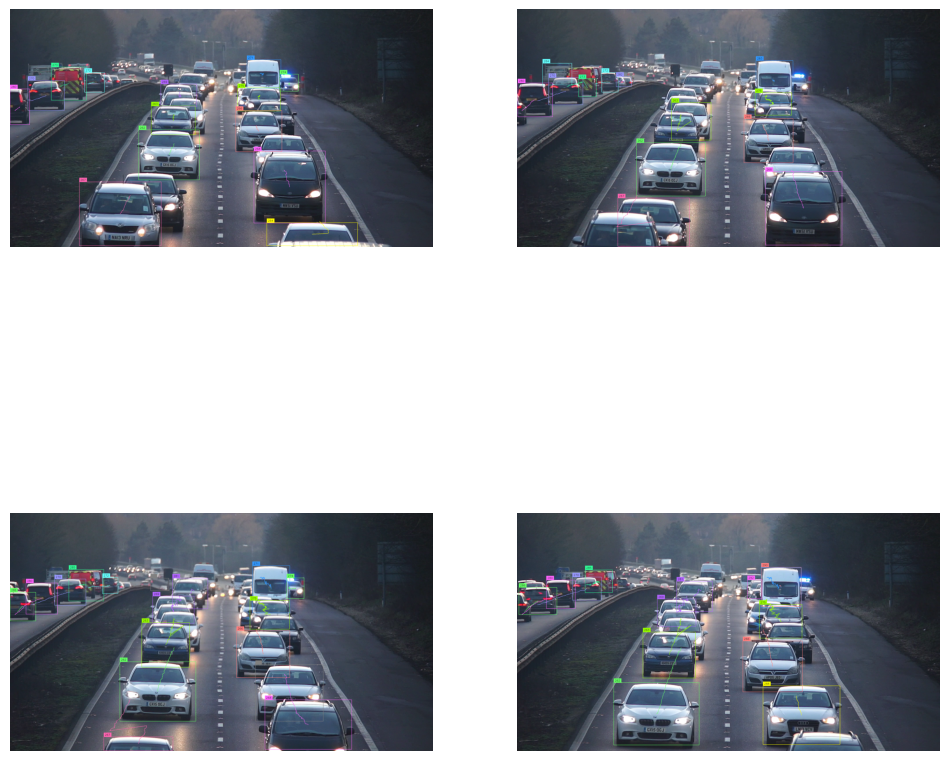

In [16]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

In [17]:
from IPython.display import Video
Video("/content/111-result.mp4", embed=True)


In [13]:
from inference import get_model
import supervision as sv
import glob
import os

# 평가용 이미지 폴더
IMAGE_DIR = "/content/eval_images"  # 라벨링된 이미지가 들어있는 폴더
LABEL_DIR = "/content/eval_labels"  # YOLO 포맷의 라벨 (.txt)

model = get_model("yolov8n-640")

# YOLO 라벨 포맷 로더
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGE_DIR,
    annotations_directory_path=LABEL_DIR,
    data_yaml_path=None
)

# mAP 계산
results = sv.metrics.detection_mean_average_precision(
    dataset=dataset,
    model=model,
)

print("mAP50:", results.map50)
print("mAP50-95:", results.map50_95)


FileNotFoundError: [Errno 2] No such file or directory: 'None'

Just combined SORT with an `inference` detector—nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).